In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, find_peaks, argrelextrema
from scipy.fft import fft, ifft
from scipy.io import loadmat
import pandas as pd
from scipy.stats import f_oneway
from sklearn.cross_decomposition import CCA
from scipy.linalg import svd
from scipy.signal import welch
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


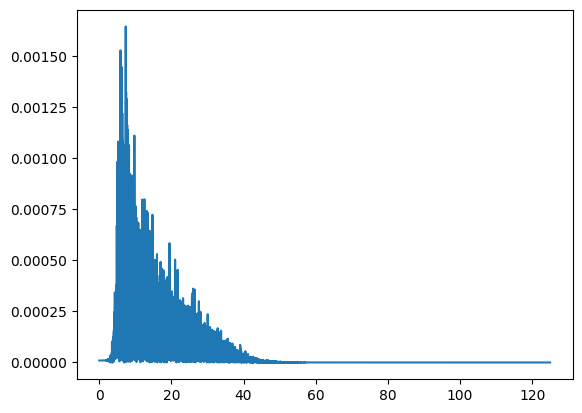

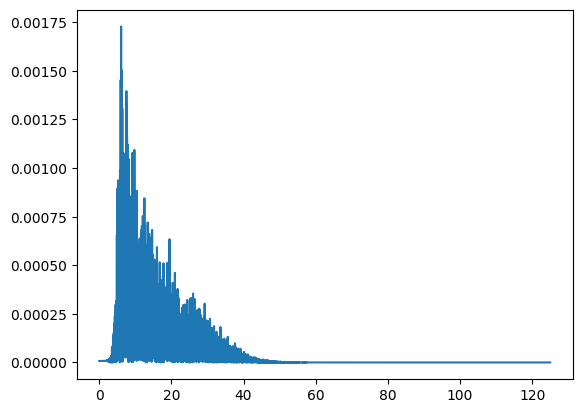

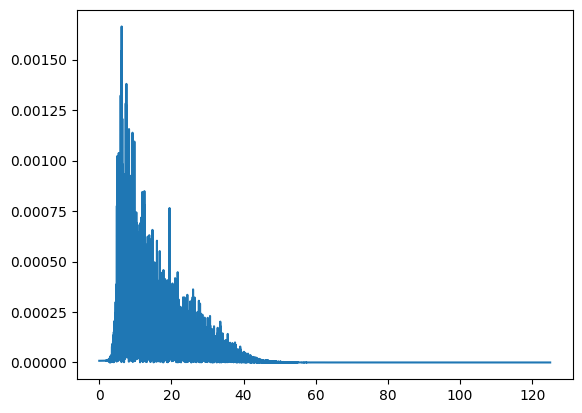

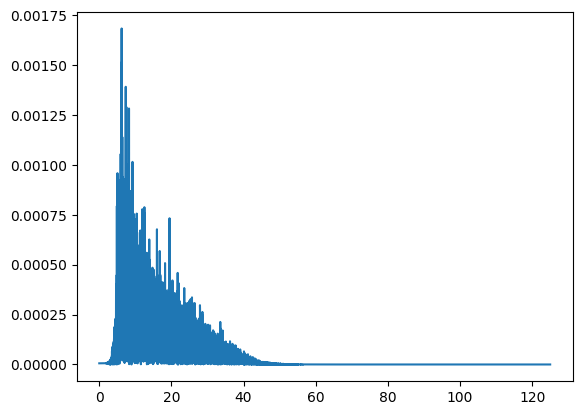

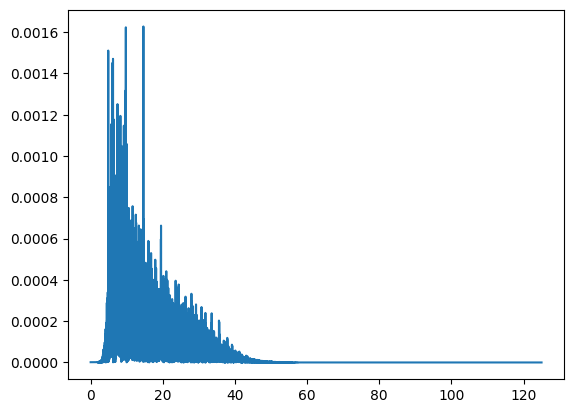

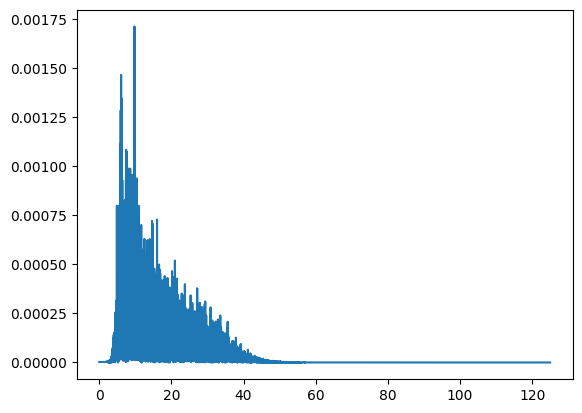

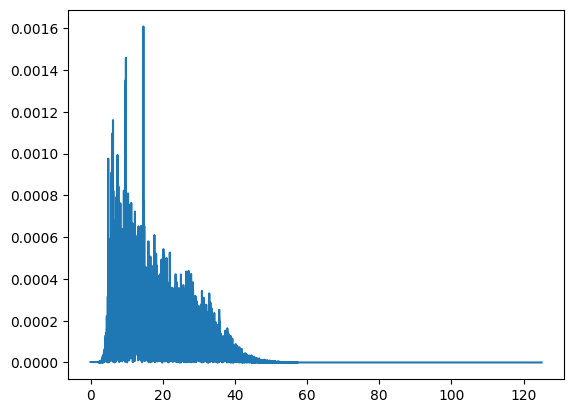

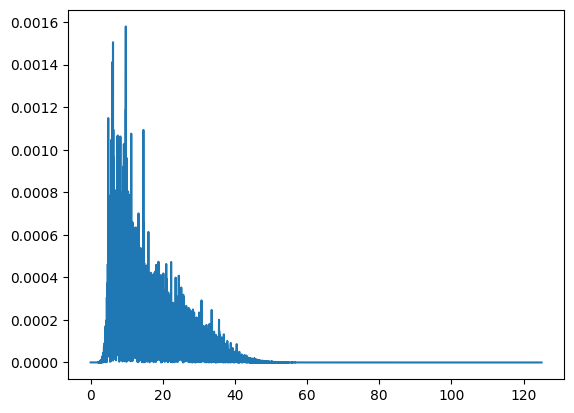

In [3]:
# Function to create a bandpass filter
def bandpass(data,lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

data = scipy.io.loadmat('/content/drive/MyDrive/LeBrain-Neureality2024/ssvep/10hz.mat')
SSVEP_Signal = data['data']

lowcut = 5
highcut = 40
fs = 250
filtered_signals = np.zeros_like(SSVEP_Signal)
for i in range(8):
    filtered_signals[i, :] = bandpass(SSVEP_Signal[i, :], lowcut, highcut, fs)

fft_data = np.zeros_like(filtered_signals, dtype=float)
nfft_data = np.zeros_like(filtered_signals, dtype=float)
for i in range(8):
  fft_data[i,:] = fft(filtered_signals[i,:])
  nfft_data[i,:] = abs(fft_data[i,:])/sum(abs(fft_data[i,:]))
  # plt.subplot(3,3,i+1)
  plt.figure()
  plt.plot(np.linspace(0, 125, 11250),nfft_data[i,:11250])#*np.linspace(0, 125, 11250))

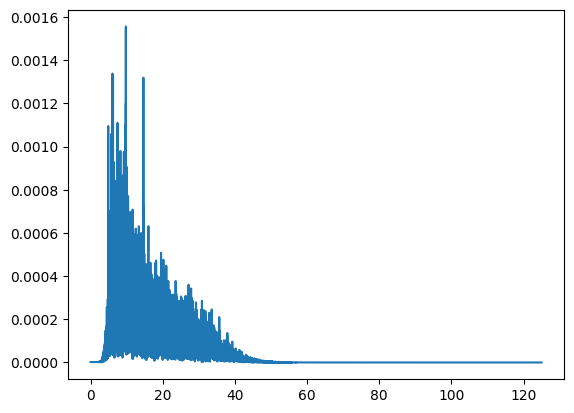

In [8]:
mfft_data = np.mean(nfft_data[4:7,:],axis=0)
plt.plot(np.linspace(0, 125, 11250),mfft_data[:11250])#*np.linspace(0, 125, 11250))

7
10
15
25
40
Actual Frequencies: [ 7 10 15 25 40]
Dominant Frequencies: [15 10 10 10 10 10 10  7 10 10 10 10 10  7 10 10]


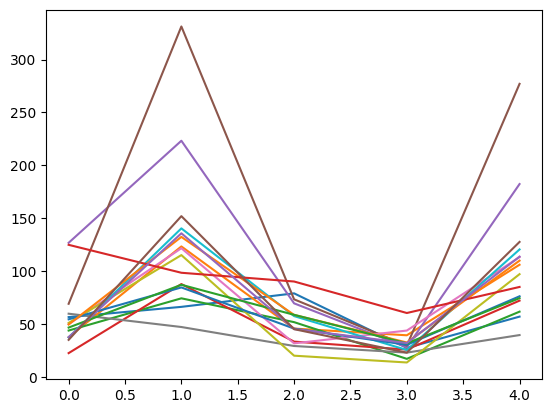

In [15]:
f = [[7,10,15,25,40]]
times = np.arange(1,250*80,250*5)
# print(times)

window_size = 5.0 #sec
overlap = 0.0

window_samples = int(window_size * fs)
overlap_samples = int(overlap * fs)

trials_cca = []
for event_sample in times:
    start_sample = int(event_sample)
    end_sample = start_sample + window_samples
    trial_data = filtered_signals[:, start_sample:end_sample]
    # print(start_sample)
    # print(end_sample)
    # print(trial_data.shape)
    trials_cca.append(trial_data)


stimulation_frequencies = list(f[0])
cca_coefficients = np.zeros((len(stimulation_frequencies), len(trials_cca)))


for i, frequency in enumerate(stimulation_frequencies):
    print(frequency)
    t = np.arange(0, 1250)
    if i>2:
        Y_f = np.vstack([[np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 8-i)]).T
        # print(Y_f.shape)
    else:
        Y_f = np.vstack([[np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 7-i)]).T
        # print(Y_f.shape)

    # for j, trial_data in enumerate(trials_cca):
    for j, trial_data in enumerate(trials_cca):
        # print(trial_data[1])
        # print(j)
        X = trial_data
        cca = CCA(n_components=4)
        X_c, Y_c = cca.fit_transform(X.T, Y_f)
        U, S, Vh = svd(np.dot(X_c.T, Y_c))
        cca_coefficients[i,j] = np.max(S)

# print(cca_coefficients)

stimulation_frequencies = np.array(stimulation_frequencies)
dominant_frequencies = stimulation_frequencies[np.argmax(cca_coefficients, axis=0)]
plt.plot(cca_coefficients)
plt.xlabel('')
# true_labels = f[0]
# accuracy = np.mean(dominant_frequencies == true_labels)
print("Actual Frequencies:", stimulation_frequencies)
print("Dominant Frequencies:", dominant_frequencies)
# print("True Labels:", true_labels)
# print("Accuracy: " + str(accuracy*100) + "%")


In [29]:
data = scipy.io.loadmat('/content/drive/MyDrive/LeBrain-Neureality2024/ssvep/35hz.mat')
SSVEP_Signal = data['data']
f = [[7,10,15,25,35]]
times = np.arange(1,250*60,250*1)

lowcut = 5.0
highcut = 50.0
fs = 250.0

filtered_signals = np.zeros_like(SSVEP_Signal)
for i in range(8):
    filtered_signals[i, :] = bandpass(SSVEP_Signal[i, :], lowcut, highcut, fs)

time_samples = np.arange(SSVEP_Signal.shape[1]) / fs

window_size = 7.0 #sec
overlap = 0.0

window_samples = int(window_size * fs)
overlap_samples = int(overlap * fs)

trials_cca = []
for event_sample in times:
    start_sample = int(event_sample)
    end_sample = start_sample + window_samples
    trial_data = filtered_signals[:, start_sample:end_sample]
    # print(start_sample)
    # print(end_sample)
    # print(trial_data.shape)
    trials_cca.append(trial_data)


stimulation_frequencies = list(f[0])
cca_coefficients_35 = np.zeros((len(stimulation_frequencies), len(trials_cca)))
# print(cca_coefficients_15.shape)

for i, frequency in enumerate(stimulation_frequencies):
    # print(frequency)
    t = np.arange(0, 250*window_size)
    if i>2:
        Y_f = np.vstack([[np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 9-i)]).T
        # print(Y_f.shape)
    else:
        Y_f = np.vstack([[np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 8-i)]).T
        # print(Y_f.shape)

    # for j, trial_data in enumerate(trials_cca):
    for j, trial_data in enumerate(trials_cca):
        # print(trial_data[1])
        # print(j)
        X = trial_data
        cca = CCA(n_components=8)
        X_c, Y_c = cca.fit_transform(X.T, Y_f)
        U, S, Vh = svd(np.dot(X_c.T, Y_c))
        cca_coefficients_35[i,j] = np.max(S)

stimulation_frequencies = np.array(stimulation_frequencies)
dominant_frequencies = stimulation_frequencies[np.argmax(cca_coefficients, axis=0)]
# plt.plot(cca_coefficients_15)
print(cca_coefficients_35.shape)

(5, 60)


In [28]:
cca_coeff = np.concatenate([cca_coefficients_8, cca_coefficients_15, cca_coefficients_25, cca_coefficients_10, cca_coefficients_35], axis=1)
print(cca_coeff.shape)

(5, 300)


In [30]:
import pandas as pd

In [31]:
cca_coeff_df = pd.DataFrame(cca_coeff)

In [ ]:
cca_coeff_df.T

,0,1,2,3
0,38.697844,102.949848,48.089371,32.644975
1,108.621763,53.584384,39.495706,19.031183
2,48.876041,77.304734,33.934441,49.659795
3,56.551526,33.047317,19.450592,30.513962
4,62.957922,33.194890,32.289493,55.864637
...,...,...,...,...
235,0.000000,0.000000,0.000000,0.000000
236,0.000000,0.000000,0.000000,0.000000
237,0.000000,0.000000,0.000000,0.000000
238,0.000000,0.000000,0.000000,0.000000


In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

# Sample DataFrame with 8 attributes and a label column
# Replace 'df' with your DataFrame
# df = ...

# Prepare sequences of 2500 rows each
sequence_length = 5
num_features = 1

X = []
y = []


df_attributes = cca_coeff_df.copy()

# for i in range(0, len(df_attributes) - sequence_length + 1, sequence_length):
#     sequence = df_attributes.iloc[i:i + sequence_length].values
#     X.append(sequence)

# X = np.array(X)

# print(X.shape)
# Determine labels based on the first row in each sequence
# y = np.array([seq[0][0] for seq in X])
y = np.concatenate([np.repeat(0,60*3),np.repeat(1,60*2)])
y = np.array(y)
one_hot_y = tf.one_hot(y, depth=4).numpy().transpose()

# Convert the list to a NumPy array
#y = np.array(y)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_attributes.T, one_hot_y.T, test_size=0.4, random_state=42)
# X =

# model = Sequential([
#     LSTM(32, return_sequences=True, input_shape=(sequence_length, num_features)),
#     Dropout(0.2),
#     LSTM(16, return_sequences=True),
#     Dropout(0.2),
#     LSTM(8),
#     Dense(2, activation='relu'),
#     Dropout(0.2),
#     Dense(4, activation='softmax')
# ])

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])


model.compile(optimizer='adam', loss='kullback_leibler_divergence', metrics=['accuracy'])

# Train the model
# model.fit(X_train, y_train, epochs=200, batch_size=4, validation_data=(X_test, y_test))
model.fit(X_train, y_train, epochs=400, batch_size=4, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/400
45/45 [==============================] - 7s 41ms/step - loss: 1.3658 - accuracy: 0.4778 - val_loss: 1.3273 - val_accuracy: 0.6000
Epoch 2/400
45/45 [==============================] - 0s 10ms/step - loss: 1.3087 - accuracy: 0.6000 - val_loss: 1.2620 - val_accuracy: 0.6000
Epoch 3/400
45/45 [==============================] - 0s 11ms/step - loss: 1.2471 - accuracy: 0.6000 - val_loss: 1.1959 - val_accuracy: 0.6000
Epoch 4/400
45/45 [==============================] - 1s 14ms/step - loss: 1.2069 - accuracy: 0.6000 - val_loss: 1.1578 - val_accuracy: 0.6000
Epoch 5/400
45/45 [==============================] - 1s 15ms/step - loss: 1.1075 - accuracy: 0.6000 - val_loss: 1.0777 - val_accuracy: 0.6000
Epoch 6/400
45/45 [==============================] - 1s 15ms/step - loss: 1.0753 - accuracy: 0.5833 - val_loss: 1.0259 - val_accuracy: 0.6000
Epoch 7/400
45/45 [==============================] - 1s 15ms/step - loss: 1.0627 - accuracy: 0.5278 - val_loss: 0.9922 - val_accuracy: 0.6000
Epoch 

,0,1,2,3,4,5,6,7,8,9,10,11,label
0,38.697844,43.636720,51.776784,50.580946,38.602401,40.601538,52.012743,84.364566,52.950925,40.635721,59.317538,48.828573,0
1,102.949848,52.916120,67.412695,21.545355,37.009387,29.055605,53.158705,51.939759,45.598542,44.205310,37.954607,54.300545,0
2,48.089371,35.166364,100.482097,27.951991,50.824355,38.651839,31.993730,71.918886,50.086486,21.690779,38.822870,36.491313,0
3,32.644975,28.026827,30.971263,22.280380,14.368560,17.671139,41.717244,30.967873,41.568005,43.855269,96.885689,26.358433,0
4,54.571120,51.001355,65.878434,117.537111,63.857591,51.741462,51.568796,88.146310,46.065137,53.091034,67.465514,66.293062,1
5,29.452499,27.474809,52.983727,57.062893,49.383233,50.218822,34.015836,52.232568,18.414603,41.539308,63.915058,50.327376,1
6,38.584867,50.768754,36.174048,37.441602,31.760567,32.661793,30.115158,31.353835,21.995749,31.670831,31.065277,30.462386,1
7,16.049638,17.869554,35.744317,50.397618,27.364737,44.040008,48.094614,50.388988,41.159977,17.073350,26.025555,37.762123,1
8,66.599893,55.295971,53.965132,89.305247,93.014153,79.538979,57.809258,85.435810,49.010536,91.240604,94.462081,40.668658,2
9,39.888918,39.651095,48.153030,47.021140,95.877905,26.600251,52.605583,42.136752,54.147171,50.724744,81.774924,58.306547,2
